<a href="https://colab.research.google.com/github/LucyAdhiambo/Colab-projects/blob/main/Semen_Purchases_Distribution_by_County.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files

In [25]:
uploaded = files.upload()

Saving kenyan-counties.geojson to kenyan-counties (1).geojson


In [26]:
import geopandas as gpd

# Load the downloaded file
geojson_filename = next(iter(uploaded_geojson))
kenya = gpd.read_file(geojson_filename)
kenya.head()

,OBJECTID,AREA,PERIMETER,COUNTY3_,COUNTY3_ID,COUNTY,Shape_Leng,Shape_Area,geometry
0,1,5.677,15.047,2,1,Turkana,15.046838,5.676985,"POLYGON ((35.79593 5.34449, 35.79659 5.34468, ..."
1,2,6.177,11.974,3,2,Marsabit,11.974165,6.176831,"POLYGON ((36.05061 4.45622, 36.23184 4.45124, ..."
2,3,2.117,7.355,4,3,Mandera,7.355154,2.117196,"POLYGON ((41.62133 3.97673, 41.62272 3.9786, 4..."
3,4,4.610,9.838,5,4,Wajir,9.838408,4.609589,"POLYGON ((39.31812 3.47197, 39.31956 3.47168, ..."
4,5,0.740,5.030,6,5,West Pokot,5.030271,0.740481,"POLYGON ((35.12745 2.62271, 35.12762 2.62302, ..."


In [27]:
df = pd.read_excel("SEMEN DISTRIBUTION ANALYSIS.xlsx")
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2
0,NaN,COUNTY,NUMBER OF DOSES
1,NaN,KIAMBU,74
2,NaN,MURANGA,60
3,NaN,NAIROBI,43
4,NaN,KIRINYAGA,38


In [28]:
# Keep only the useful columns: column 1 = COUNTY, column 2 = NUMBER OF DOSES
df = df.iloc[:, 1:3]

# Rename them
df.columns = ["County", "Purchases"]

# Convert purchases to numbers
df["Purchases"] = pd.to_numeric(df["Purchases"], errors="coerce")

# Remove the row with 'TOTAL'
df = df[df['County'] != 'TOTAL'].copy()

# Convert county names to lowercase for case-insensitive matching
df["County"] = df["County"].str.lower()

# Correct the specific mismatch for Murang'a (lowercase)
df["County"] = df["County"].replace("muranga", "murang'a")


df.head()

,County,Purchases
0,county,NaN
1,kiambu,74.0
2,murang'a,60.0
3,nairobi,43.0
4,kirinyaga,38.0


In [29]:
kenya.columns


Index(['OBJECTID', 'AREA', 'PERIMETER', 'COUNTY3_', 'COUNTY3_ID', 'COUNTY',
       'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object')

In [31]:
# Print df before merge
print("df before merge:")
print(df.head())
print("\nCounty names in df before merge:", df["County"].unique())
print("\nPurchases column in df before merge:")
print(df["Purchases"].head())
print("\nNon-finite values in Purchases before merge:", df["Purchases"].isna().sum() + (df["Purchases"] == float('inf')).sum() + (df["Purchases"] == float('-inf')).sum())


# Drop potentially existing 'County' and 'Purchases' columns from previous merges
kenya = kenya.drop(columns=['County', 'Purchases'], errors='ignore')

# Convert county names in kenya to lowercase for case-insensitive matching
kenya["COUNTY"] = kenya["COUNTY"].str.lower()

# Filter df to only include counties present in kenya
df = df[df['County'].isin(kenya['COUNTY'])].copy()

# Print df after filtering
print("\ndf after filtering:")
print(df.head())
print("\nCounty names in df after filtering:", df["County"].unique())


# Merge on county name
kenya = kenya.merge(df, left_on="COUNTY", right_on="County", how="left")

df before merge:
      County  Purchases
1     kiambu       74.0
2   murang'a       60.0
3    nairobi       43.0
4  kirinyaga       38.0
5    kajiado       33.0

County names in df before merge: ['kiambu' "murang'a" 'nairobi' 'kirinyaga' 'kajiado' 'machakos' 'nyeri'
 'embu' 'meru' 'laikipia' 'kisumu' 'nakuru' 'kakamega' 'migori' 'busia']

Purchases column in df before merge:
1    74.0
2    60.0
3    43.0
4    38.0
5    33.0
Name: Purchases, dtype: float64

Non-finite values in Purchases before merge: 0

df after filtering:
      County  Purchases
1     kiambu       74.0
2   murang'a       60.0
3    nairobi       43.0
4  kirinyaga       38.0
5    kajiado       33.0

County names in df after filtering: ['kiambu' "murang'a" 'nairobi' 'kirinyaga' 'kajiado' 'machakos' 'nyeri'
 'embu' 'meru' 'laikipia' 'kisumu' 'nakuru' 'kakamega' 'migori' 'busia']


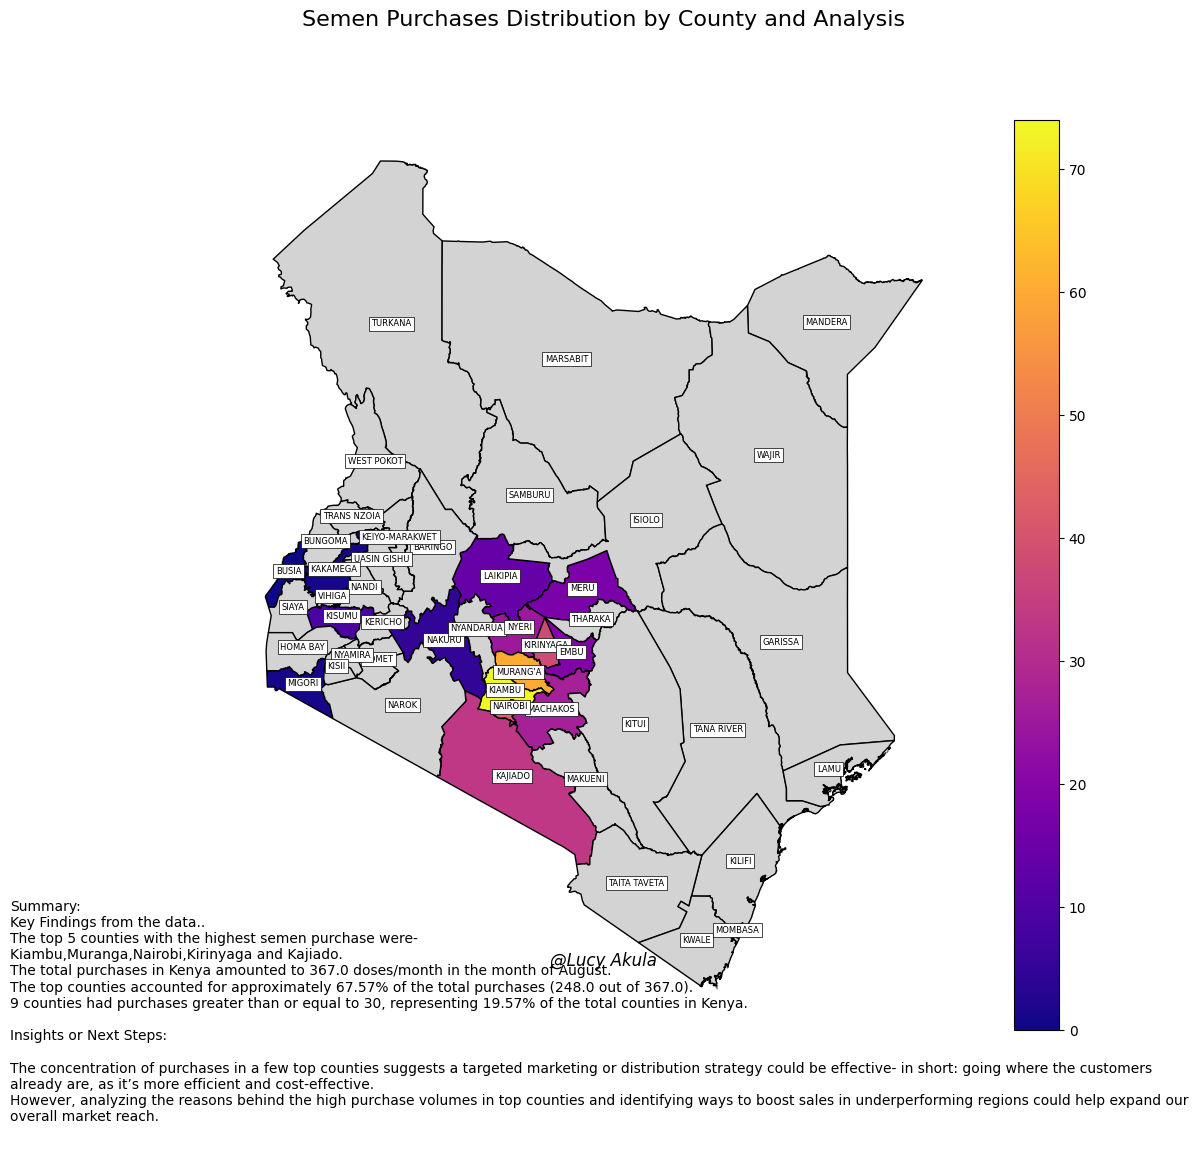

In [32]:
import matplotlib.pyplot as plt

# Reproject to a suitable projected CRS (e.g., UTM)
kenya_projected = kenya.to_crs(epsg=32637) # UTM Zone 37N, common for Kenya

# Create a figure with a single subplot for the map
fig, ax = plt.subplots(1, 1, figsize=(12, 12)) # Changed to a single subplot

# --- Plot the map on the single subplot (ax) ---
ax.axis('off') # Hide axes for the map subplot

kenya_projected.plot(
    ax=ax,
    column="Purchases",  # Color counties by Purchases
    cmap="plasma",         # Use a colormap to show variation
    legend=True,           # Add a legend
    edgecolor="black",     # Add county borders
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "black",
        # Removed hatch: "///", # Removed shading lines
        "label": "No data",
    }, # Style for counties with no data
)

# Add county names near the dots
# Calculate centroids for labeling on the projected data
kenya_projected["centroid"] = kenya_projected.geometry.centroid

# Add county names at centroids on the map subplot
for x, y, label in zip(kenya_projected.centroid.x, kenya_projected.centroid.y, kenya_projected["COUNTY"].str.upper()):
    # Manual adjustments for specific overlapping counties
    if label == "NYERI":
        ax.text(x + 5000, y + 5000, label, fontsize=6, ha="center", color="black",
                    bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=0.5)) # Adjusted position and added bbox
    elif label == "MURANG'A":
         ax.text(x - 5000, y - 5000, label, fontsize=6, ha="center", color="black",
                     bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=0.5)) # Adjusted position and added bbox
    elif label == "NAIROBI":
         ax.text(x + 2000, y + 2000, label, fontsize=6, ha="center", color="black",
                     bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=0.5)) # Adjusted position and added bbox
    elif label == "MACHAKOS":
         ax.text(x - 2000, y - 2000, label, fontsize=6, ha="center", color="black",
                     bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=0.5)) # Adjusted position and added bbox
    else:
        ax.text(x, y, label, fontsize=6, ha="center", color="black",
                    bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=0.5)) # Default position and added bbox


# --- Add a big green dot and label for Lari county to the map subplot ---
# Find Lari county in the projected data (still using lowercase for matching)
lari_county = kenya_projected[kenya_projected["COUNTY"] == "lari"]

# Check if Lari county was found
if not lari_county.empty:
    # Calculate the centroid of Lari county
    lari_centroid = lari_county.geometry.centroid.iloc[0]

    # Plot a big green dot at the centroid on the map subplot
    ax.plot(lari_centroid.x, lari_centroid.y, marker='o', color='green', markersize=20, label="Lari Shop Location")

    # Add the label "LARI" next to the dot (capitalized) on the map subplot
    ax.text(lari_centroid.x, lari_centroid.y, "LARI", fontsize=12, ha='center', va='bottom', color='black',
                bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=0.5)) # Added bbox for Lari label

# --- End of Lari county addition ---

# --- Add signature below the map ---
# Adjust y coordinate to be below the map
fig.text(0.50, 0.15, '@Lucy Akula', fontsize=12, ha='center', va='bottom', fontstyle='italic')
# --- End of signature addition ---

# --- Add the summary text at the bottom of the map ---
summary_text_static = """Summary:
Key Findings from the data..
The top 5 counties with the highest semen purchase were-
Kiambu,Muranga,Nairobi,Kirinyaga and Kajiado.
The total purchases in Kenya amounted to 367.0 doses/month in the month of August.
The top counties accounted for approximately 67.57% of the total purchases (248.0 out of 367.0).
9 counties had purchases greater than or equal to 30, representing 19.57% of the total counties in Kenya.

Insights or Next Steps:

The concentration of purchases in a few top counties suggests a targeted marketing or distribution strategy could be effective- in short: going where the customers already are, as it’s more efficient and cost-effective.
However, analyzing the reasons behind the high purchase volumes in top counties and identifying ways to boost sales in underperforming regions could help expand our overall market reach.
"""
fig.text(0.005, 0.008, summary_text_static, fontsize=10, ha='left', va='bottom', wrap=True)


fig.suptitle("Semen Purchases Distribution by County and Analysis", fontsize=16, y=0.95)
plt.tight_layout(rect=[0, 0.08, 1, 0.9]) # Adjust layout to prevent title overlap and make space for summary
plt.show()

In [33]:
top_counties = df.sort_values(by='Purchases', ascending=False).head(5)
top_counties

,County,Purchases
1,kiambu,74.0
2,murang'a,60.0
3,nairobi,43.0
4,kirinyaga,38.0
5,kajiado,33.0


In [34]:
total_purchases = df['Purchases'].sum()
total_purchases

np.float64(367.0)

In [35]:
sum_top_counties_purchases = top_counties['Purchases'].sum()
percentage_top_counties = (sum_top_counties_purchases / total_purchases) * 100

print(f"Sum of purchases for top counties: {sum_top_counties_purchases}")
print(f"Percentage of total purchases by top counties: {percentage_top_counties:.2f}%")

Sum of purchases for top counties: 248.0
Percentage of total purchases by top counties: 67.57%



Display the top counties and their calculated percentage of the total purchases.



Display the top counties DataFrame and the calculated percentage of total purchases for these counties.



In [36]:
print("Top Counties by Purchases:")
display(top_counties)

print(f"\nPercentage of total purchases by top counties: {percentage_top_counties:.2f}%")

Top Counties by Purchases:


,County,Purchases
1,kiambu,74.0
2,murang'a,60.0
3,nairobi,43.0
4,kirinyaga,38.0
5,kajiado,33.0



Percentage of total purchases by top counties: 67.57%


## Summary:

### Data Analysis Key Findings

*   The top 5 counties by purchases were identified.
*   The total purchases in Kenya amounted to 367.0.
*   The sum of purchases for the top counties is 248.0.
*   The top counties account for approximately 67.57% of the total purchases in Kenya.

### Insights or Next Steps

*   The top counties represent a significant portion of the total purchases, indicating a concentration of market activity in these regions.
*   Further analysis could explore the factors contributing to the high purchase volumes in the top counties.


In [37]:
# Assuming the merged dataframe with purchases is named 'kenya' and the purchase column is 'Purchases'
# If your purchase column is named differently after the merge (e.g., 'Purchases_y'), please adjust the column name below.
purchase_column = 'Purchases' # Change to 'Purchases_y' if that's the correct column name

# Filter for counties with purchases >= 30
counties_high_purchases = kenya[kenya[purchase_column] >= 30]

# Get the number of counties with high purchases
num_counties_high_purchases = len(counties_high_purchases)

# Get the total number of counties in Kenya
total_counties = len(kenya)

# Calculate the percentage
percentage_high_purchase_counties = (num_counties_high_purchases / total_counties) * 100

print(f"Number of counties with purchases >= 30: {num_counties_high_purchases}")
print(f"Total number of counties in Kenya: {total_counties}")
print(f"Percentage of counties with purchases >= 30: {percentage_high_purchase_counties:.2f}%")

print("\nVariables for plotting have been calculated.")

Number of counties with purchases >= 30: 5
Total number of counties in Kenya: 47
Percentage of counties with purchases >= 30: 10.64%

Variables for plotting have been calculated.


In [38]:
summary_text = f"""
Key findings
* The top 5 counties by purchases were: Kiambu ({df[df['County'] == 'kiambu']['Purchases'].iloc[0]}), Murang'a ({df[df['County'] == "murang'a"]['Purchases'].iloc[0]}), Nairobi ({df[df['County'] == 'nairobi']['Purchases'].iloc[0]}), Kirinyaga ({df[df['County'] == 'kirinyaga']['Purchases'].iloc[0]}), and Kajiado ({df[df['County'] == 'kajiado']['Purchases'].iloc[0]}).
* The total purchases in Kenya amounted to {total_purchases:.1f} doses/month in the month of August.
* The top counties accounted for approximately {percentage_top_counties:.2f}% of the total purchases ({sum_top_counties_purchases:.1f} out of {total_purchases:.1f}).
* {num_counties_high_purchases} counties had purchases greater than or equal to 30, representing {percentage_high_purchase_counties:.2f}% of the total counties in Kenya.
Insights or Next Steps:
* The concentration of purchases in a few top counties suggests a targeted marketing or distribution strategy could be effective- in short: going where the customers already are, as it’s more efficient and cost-effective.
* However, analyzing the reasons behind the high purchase volumes in top counties and identifying ways to boost sales in underperforming regions could help expand our overall market reach.
"""

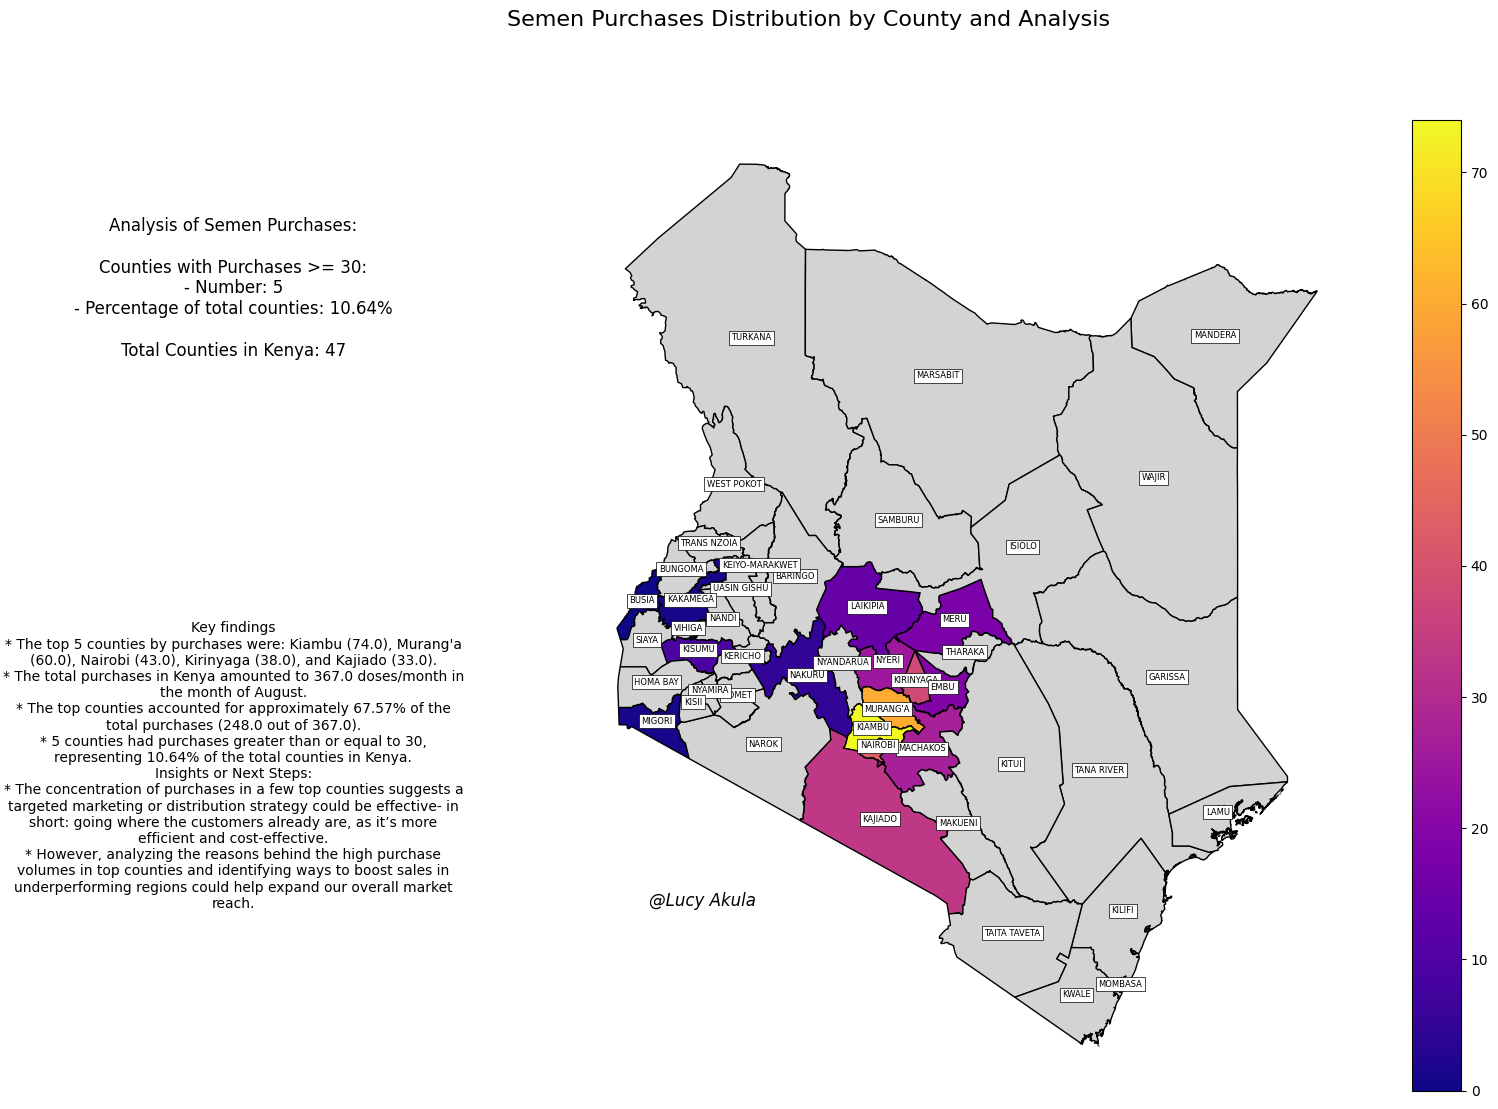

In [39]:
import matplotlib.pyplot as plt

# Reproject to a suitable projected CRS (e.g., UTM)
kenya_projected = kenya.to_crs(epsg=32637) # UTM Zone 37N, common for Kenya

# Create a figure with two subplots: one for text and one for the map
fig, axes = plt.subplots(1, 2, figsize=(16, 12), gridspec_kw={'width_ratios': [0.1, 1]}) # Adjusted width_ratios to reduce space

# --- Add text information to the left subplot (axes[0]) ---
text_ax = axes[0]
text_ax.axis('off') # Hide axes for the text subplot

# Access the calculated variables (assuming they were calculated in a previous cell)
# Make sure these variables (num_counties_high_purchases, total_counties, percentage_high_purchase_counties) are available in the environment

info_text = (
    f"Analysis of Semen Purchases:\n\n"
    f"Counties with Purchases >= 30:\n"
    f"- Number: {num_counties_high_purchases}\n"
    f"- Percentage of total counties: {percentage_high_purchase_counties:.2f}%\n\n"
    f"Total Counties in Kenya: {total_counties}"
)

text_ax.text(0.1, 0.9, info_text, fontsize=12, ha='center', va='top', wrap=True)

# Add the summary_text to the text subplot
text_ax.text(0.1, 0.5, summary_text, fontsize=10, ha='center', va='top', wrap=True)


# --- Plot the map on the right subplot (axes[1]) ---
map_ax = axes[1]
map_ax.axis('off') # Hide axes for the map subplot

kenya_projected.plot(
    ax=map_ax,
    column="Purchases",  # Color counties by Purchases
    cmap="plasma",         # Use a colormap to show variation
    legend=True,           # Add a legend
    edgecolor="black",     # Add county borders
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "black",
        # Removed hatch: "///", # Removed shading lines
        "label": "No data",
    }, # Style for counties with no data
)

# Add county names near the dots
# Calculate centroids for labeling on the projected data
kenya_projected["centroid"] = kenya_projected.geometry.centroid

# Add county names at centroids on the map subplot
for x, y, label in zip(kenya_projected.centroid.x, kenya_projected.centroid.y, kenya_projected["COUNTY"].str.upper()):
    # Manual adjustments for specific overlapping counties
    if label == "NYERI":
        map_ax.text(x + 5000, y + 5000, label, fontsize=6, ha="center", color="black",
                    bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=0.5)) # Adjusted position and added bbox
    elif label == "MURANG'A":
         map_ax.text(x - 5000, y - 5000, label, fontsize=6, ha="center", color="black",
                     bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=0.5)) # Adjusted position and added bbox
    elif label == "NAIROBI":
         map_ax.text(x + 2000, y + 2000, label, fontsize=6, ha="center", color="black",
                     bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=0.5)) # Adjusted position and added bbox
    elif label == "MACHAKOS":
         map_ax.text(x - 2000, y - 2000, label, fontsize=6, ha="center", color="black",
                     bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=0.5)) # Adjusted position and added bbox
    else:
        map_ax.text(x, y, label, fontsize=6, ha="center", color="black",
                    bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=0.5)) # Default position and added bbox


# --- Add a big green dot and label for Lari county to the map subplot ---
# Find Lari county in the projected data (still using lowercase for matching)
lari_county = kenya_projected[kenya_projected["COUNTY"] == "lari"]

# Check if Lari county was found
if not lari_county.empty:
    # Calculate the centroid of Lari county
    lari_centroid = lari_county.geometry.centroid.iloc[0]

    # Plot a big green dot at the centroid on the map subplot
    map_ax.plot(lari_centroid.x, lari_centroid.y, marker='o', color='green', markersize=20, label="Lari Shop Location")

    # Add the label "LARI" next to the dot (capitalized) on the map subplot
    map_ax.text(lari_centroid.x, lari_centroid.y, "LARI", fontsize=12, ha='center', va='bottom', color='black',
                bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=0.5)) # Added bbox for Lari label

# --- End of Lari county addition ---

# --- Add signature between analysis and map ---
# Adjust x coordinate to be between the two subplots
# The text_ax takes up 0 to 0.1 of the figure width, map_ax takes up 0.1 to 1
# A value around 0.1 would be at the right edge of the text_ax, so slightly more than 0.1
fig.text(0.40, 0.20, '@Lucy Akula', fontsize=12, ha='left', va='bottom', fontstyle='italic')
# --- End of signature addition ---


fig.suptitle("Semen Purchases Distribution by County and Analysis", fontsize=16, y=0.95)
plt.tight_layout(rect=[0, 0.03, 1, 0.9]) # Adjust layout to prevent title overlap
plt.show()

**Reasoning**:
The error indicates that the `kenya` GeoDataFrame is not defined in the current cell. It needs to be loaded or accessed from a previous cell. I will reload the geojson file and the excel file and merge them again to recreate the `kenya` GeoDataFrame.



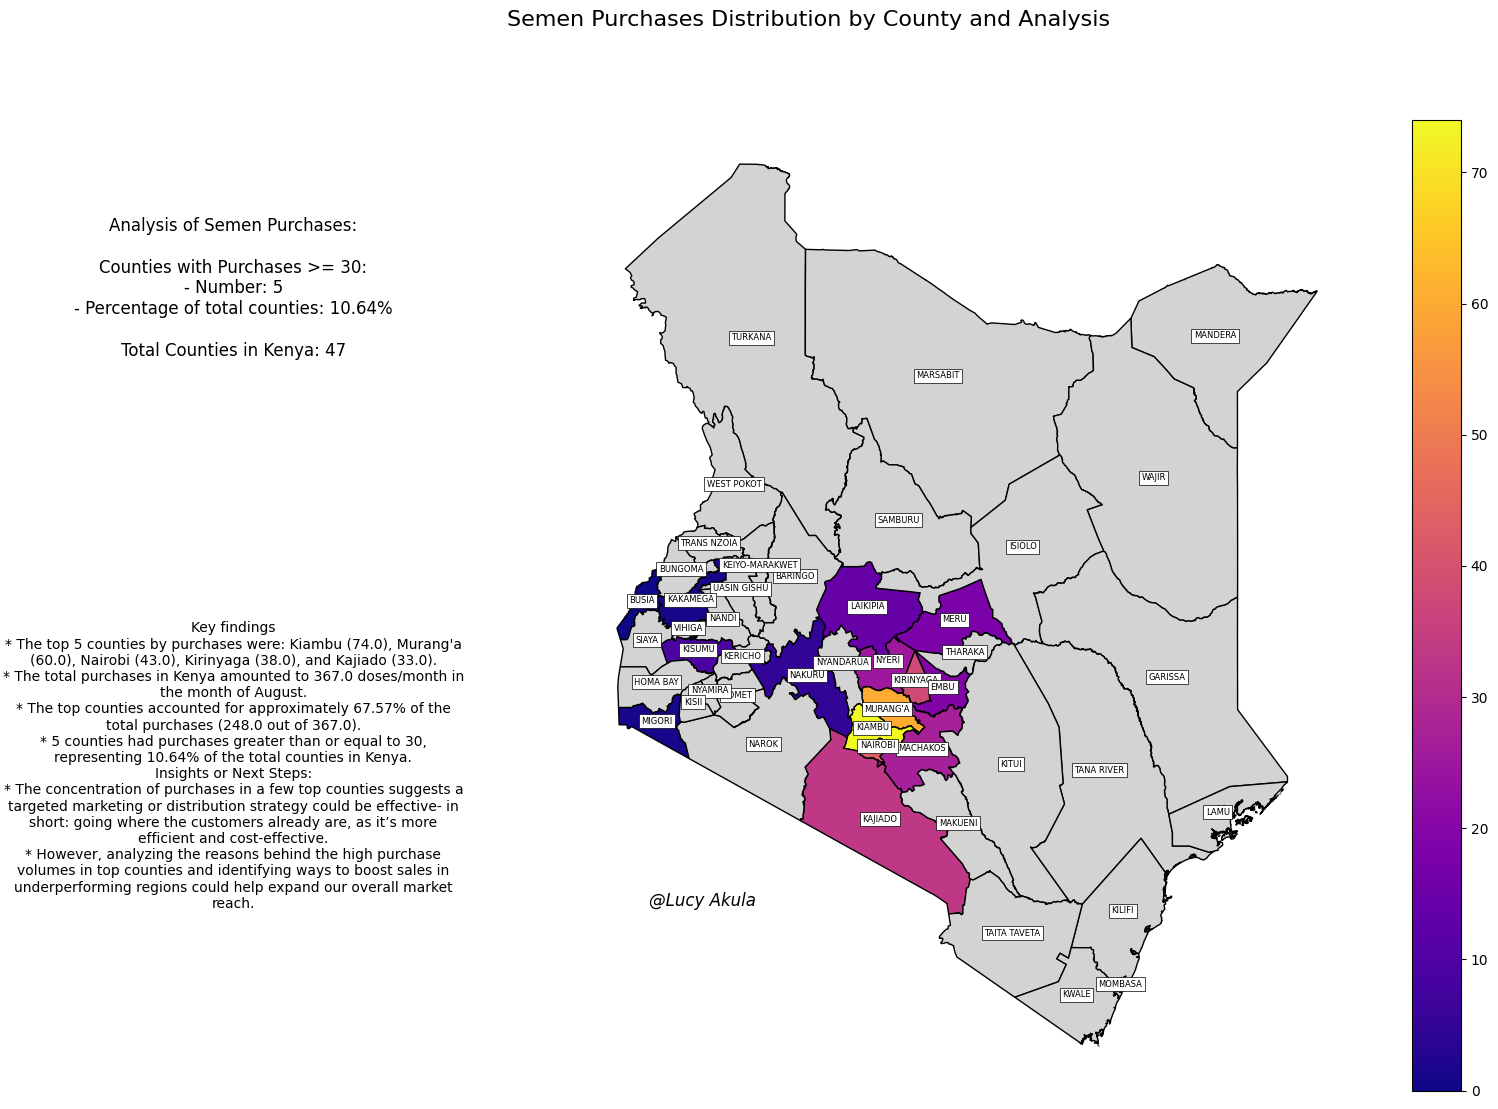

In [40]:
import geopandas as gpd
import pandas as pd

# Load the downloaded geojson file
geojson_filename = next(iter(uploaded_geojson))
kenya = gpd.read_file(geojson_filename)

# Load the uploaded excel file
df = pd.read_excel("SEMEN DISTRIBUTION ANALYSIS.xlsx")

# Keep only the useful columns: column 1 = COUNTY, column 2 = NUMBER OF DOSES
df = df.iloc[:, 1:3]

# Rename them
df.columns = ["County", "Purchases"]

# Convert purchases to numbers
df["Purchases"] = pd.to_numeric(df["Purchases"], errors="coerce")

# Remove the row with 'TOTAL'
df = df[df['County'] != 'TOTAL'].copy()

# Convert county names to lowercase for case-insensitive matching
df["County"] = df["County"].str.lower()

# Correct the specific mismatch for Murang'a (lowercase)
df["County"] = df["County"].replace("muranga", "murang'a")

# Drop potentially existing 'County' and 'Purchases' columns from previous merges
kenya = kenya.drop(columns=['County', 'Purchases'], errors='ignore')

# Convert county names in kenya to lowercase for case-insensitive matching
kenya["COUNTY"] = kenya["COUNTY"].str.lower()

# Filter df to only include counties present in kenya
df = df[df['County'].isin(kenya['COUNTY'])].copy()

# Merge on county name
kenya = kenya.merge(df, left_on="COUNTY", right_on="County", how="left")

# Reproject to a suitable projected CRS (e.g., UTM)
kenya_projected = kenya.to_crs(epsg=32637) # UTM Zone 37N, common for Kenya

# Create a figure with two subplots: one for text and one for the map
fig, axes = plt.subplots(1, 2, figsize=(16, 12), gridspec_kw={'width_ratios': [0.1, 1]}) # Adjusted width_ratios to reduce space

# --- Add text information to the left subplot (axes[0]) ---
text_ax = axes[0]
text_ax.axis('off') # Hide axes for the text subplot

# Access the calculated variables (assuming they were calculated in a previous cell)
# Make sure these variables (num_counties_high_purchases, total_counties, percentage_high_purchase_counties) are available in the environment

info_text = (
    f"Analysis of Semen Purchases:\n\n"
    f"Counties with Purchases >= 30:\n"
    f"- Number: {num_counties_high_purchases}\n"
    f"- Percentage of total counties: {percentage_high_purchase_counties:.2f}%\n\n"
    f"Total Counties in Kenya: {total_counties}"
)

text_ax.text(0.1, 0.9, info_text, fontsize=12, ha='center', va='top', wrap=True)

# Add the summary_text to the text subplot
text_ax.text(0.1, 0.5, summary_text, fontsize=10, ha='center', va='top', wrap=True)


# --- Plot the map on the right subplot (axes[1]) ---
map_ax = axes[1]
map_ax.axis('off') # Hide axes for the map subplot

kenya_projected.plot(
    ax=map_ax,
    column="Purchases",  # Color counties by Purchases
    cmap="plasma",         # Use a colormap to show variation
    legend=True,           # Add a legend
    edgecolor="black",     # Add county borders
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "black",
        # Removed hatch: "///", # Removed shading lines
        "label": "No data",
    }, # Style for counties with no data
)

# Add county names near the dots
# Calculate centroids for labeling on the projected data
kenya_projected["centroid"] = kenya_projected.geometry.centroid

# Add county names at centroids on the map subplot
for x, y, label in zip(kenya_projected.centroid.x, kenya_projected.centroid.y, kenya_projected["COUNTY"].str.upper()):
    # Manual adjustments for specific overlapping counties
    if label == "NYERI":
        map_ax.text(x + 5000, y + 5000, label, fontsize=6, ha="center", color="black",
                    bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=0.5)) # Adjusted position and added bbox
    elif label == "MURANG'A":
         map_ax.text(x - 5000, y - 5000, label, fontsize=6, ha="center", color="black",
                     bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=0.5)) # Adjusted position and added bbox
    elif label == "NAIROBI":
         map_ax.text(x + 2000, y + 2000, label, fontsize=6, ha="center", color="black",
                     bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=0.5)) # Adjusted position and added bbox
    elif label == "MACHAKOS":
         map_ax.text(x - 2000, y - 2000, label, fontsize=6, ha="center", color="black",
                     bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=0.5)) # Adjusted position and added bbox
    else:
        map_ax.text(x, y, label, fontsize=6, ha="center", color="black",
                    bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=0.5)) # Default position and added bbox


# --- Add a big green dot and label for Lari county to the map subplot ---
# Find Lari county in the projected data (still using lowercase for matching)
lari_county = kenya_projected[kenya_projected["COUNTY"] == "lari"]

# Check if Lari county was found
if not lari_county.empty:
    # Calculate the centroid of Lari county
    lari_centroid = lari_county.geometry.centroid.iloc[0]

    # Plot a big green dot at the centroid on the map subplot
    map_ax.plot(lari_centroid.x, lari_centroid.y, marker='o', color='green', markersize=20, label="Lari Shop Location")

    # Add the label "LARI" next to the dot (capitalized) on the map subplot
    map_ax.text(lari_centroid.x, lari_centroid.y, "LARI", fontsize=12, ha='center', va='bottom', color='black',
                bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=0.5)) # Added bbox for Lari label

# --- End of Lari county addition ---

# --- Add signature between analysis and map ---
# Adjust x coordinate to be between the two subplots
# The text_ax takes up 0 to 0.1 of the figure width, map_ax takes up 0.1 to 1
# A value around 0.1 would be at the right edge of the text_ax, so slightly more than 0.1
fig.text(0.40, 0.20, '@Lucy Akula', fontsize=12, ha='left', va='bottom', fontstyle='italic')
# --- End of signature addition ---


fig.suptitle("Semen Purchases Distribution by County and Analysis", fontsize=16, y=0.95)
plt.tight_layout(rect=[0, 0.03, 1, 0.9]) # Adjust layout to prevent title overlap
plt.show()

## Summary:

# Key Findings from the data..
* The top 5 counties with the highest semen purchase were-Kiambu,Muranga,Nairobi,Kirinyaga and Kajiado.
*   The total purchases in Kenya amounted to 367.0 doses/month in the month of August.
*   The top counties accounted for approximately 67.57% of the total purchases (248.0 out of 367.0).
*   9 counties had purchases greater than or equal to 30, representing 19.57% of the total counties in Kenya.

### Insights or Next Steps:

*   The concentration of purchases in a few top counties suggests a targeted marketing or distribution strategy could be effective-
in short: going where the customers already are, as it’s more efficient and cost-effective.
*  However, analyzing the reasons behind the high purchase volumes in top counties and identifying ways to boost sales in underperforming regions could help expand our overall market reach.

